# Issue 6: Rio Grande - examine individual events

In [170]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

## Definition of functions

In [171]:
def read_group(gruppe,loc):
    station = loc #ersten Buchstaben bitte bitte groß schreiben
    
    if loc=='Rio':
        timestart = '2008-02-01'
        timeend = '2019-12-31'
    elif loc == 'Col':
        timestart =  '2004-08-01'
        timeend =  '2019-03-06'
    elif loc=='CMA':
        timestart = '2002-01-01'
        timeend = '2018-12-31'
    elif loc=='Dav':
        timestart = '2005-01-01'
        timeend ='2019-12-31'
    elif loc=='Kir':
        timestart = '1999-08-01'
        timeend ='2019-12-31'
    
    infiles = f'{root_path}{station}/Meteor_radar_{station}_GW_*.h5'
    if gruppe == 'tides':
        ds = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_4', group = gruppe, combine='nested', parallel = True)
        ds = ds.rename({'phony_dim_4': 'time', 'phony_dim_5': 'alt'})
    else:
        ds = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_6', group = gruppe, combine='nested', parallel = True)
        ds = ds.rename({'phony_dim_6': 'time', 'phony_dim_7': 'alt'})
    ds['alt'] = alt
    ds['alt'].attrs['units'] = 'km'
    # change time range according to meteor radar station
    ds['time'] = pd.date_range(start = timestart, end = timeend, periods = ds.time.shape[0]) 
    return ds

In [172]:
def read_var(gruppe, var):
        varout = gruppe[var]
        return varout

In [173]:
def time_mean(step,var):
    return var.resample(time='1'+step).mean('time') #Immer nur D oder M oder H oder Y eintragen! Mit Anführungszeichen!

In [174]:
def anomalie(step,var):
    string = "time."+step   
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology
    
    return anomalies

In [175]:
def sea(days_period,station,var, ave_f =xr.DataArray.mean):
    df_dates = pd.read_csv('ssw_dates_displ_'+station+'_without_final_warmings.csv') # you can load SSWs from a csv file like attached
    dates = df_dates.set_index('BeginDate')

    xa_ls = []
    max_lag = days_period
    for il, days in enumerate(range(-max_lag,max_lag+1)):  
        sel_dates = pd.to_datetime(dates.index) + pd.Timedelta(str(days)+' days')
        mask = np.in1d(var.time.dt.floor('1D'),sel_dates)
        comp_m = ave_f(var.sel(time = mask),'time')
        xa_ls.append(comp_m)
   
    xa_comp = xr.concat(xa_ls, dim = 'days')
    xa_comp['days'] = range(-max_lag, max_lag+1)

    # print(xa_comp'
    return xa_comp

In [176]:
alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/'

## Rio Grande

### Hourly datasets without final warmings

#### Mean

In [177]:
ds_rio = read_group('wind','Rio')
u_rio = read_var(ds_rio,'u')  
v_rio = read_var(ds_rio,'v')

u_rio_anomalie = anomalie('day',u_rio)
# u_rio_anomalie.plot(x='time',robust=True)

v_rio_anomalie = anomalie('day',v_rio)

sea_u_rio = sea(30,'Rio',u_rio)
sea_u_rio_anomalie = sea(30,'Rio',u_rio_anomalie)

sea_v_rio = sea(30,'Rio',v_rio)
sea_v_rio_anomalie = sea(30,'Rio',v_rio_anomalie)

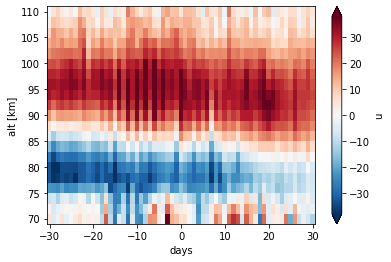

In [178]:
ax33 = sea_u_rio.sel(alt = slice(70,110)).plot(x='days',robust=True)

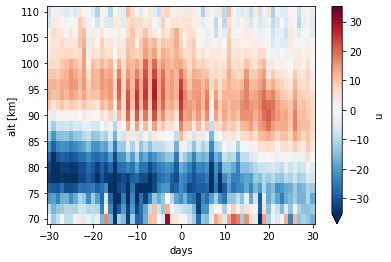

In [179]:
ax34 = sea_u_rio_anomalie.sel(alt = slice(70,110)).plot(x='days',robust=True)

#### Median

In [180]:
ds_rio = read_group('wind','Rio')
u_rio = read_var(ds_rio,'u')  
v_rio = read_var(ds_rio,'v')

u_rio_anomalie = anomalie('day',u_rio)
# u_rio_anomalie.plot(x='time',robust=True)

v_rio_anomalie = anomalie('day',v_rio)

sea_u_rio_med = sea(30,'Rio',u_rio, ave_f=xr.DataArray.median)
sea_u_rio_anomalie_med = sea(30,'Rio',u_rio_anomalie, ave_f=xr.DataArray.median)

sea_v_rio_med = sea(30,'Rio',v_rio, ave_f=xr.DataArray.median)
sea_v_rio_anomalie_med = sea(30,'Rio',v_rio_anomalie, ave_f=xr.DataArray.median)

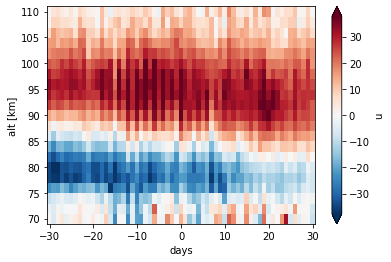

In [181]:
ax35 = sea_u_rio_med.sel(alt = slice(70,110)).plot(x='days',robust=True)

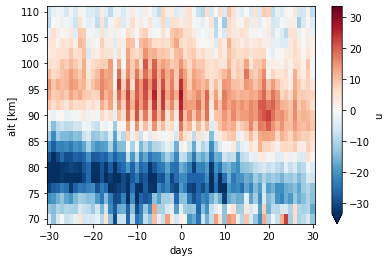

In [182]:
ax36 = sea_u_rio_anomalie_med.sel(alt = slice(70,110)).plot(x='days',robust=True)

No obvious differences between using mean and median for the superposed epoch analysis of the zonal wind are apparent.

### Individual events

In [212]:
def sea_individual(days_period,station,var):
    df_dates = pd.read_csv('ssw_dates_displ_'+station+'_without_final_warmings.csv') # you can load SSWs from a csv file like attached
    dates = df_dates.set_index('BeginDate')

    xa_ls = []
    
    print(dates.index)
    
    for days in dates.index:
        
        td = pd.Timedelta(str(days_period)+' days')  # define timedelta e.g., +/- 30 days 
        comp_m = var.sel(time = slice(pd.to_datetime(days)-td,pd.to_datetime(days)+td))  # select the data in the time range around the SSW onset
        comp_m['time'] = np.linspace(-days_period,days_period,comp_m.time.shape[0])  # set the time dimension of comp_m to an array of +/- the period
        xa_ls.append(comp_m)  # xa_ls is an array of the datasets of all single events
        
   
    xa_comp = xr.concat(xa_ls, dim = 'event')  # assign 'event' as new dimension to the data array --> new array xa_comp
    xa_comp['event'] = dates.index.values   # xa_comp has now the dimension 'event' and the values of this dimension are the indices of dates (i.e. the dates of the SSW onsets)

    return xa_comp

In [213]:
sea_u_rio_individual = sea_individual(30,'Rio',u_rio)
sea_u_rio_individual_anomalie = sea_individual(30,'Rio',u_rio_anomalie)

sea_v_rio = sea_individual(30,'Rio',v_rio)
sea_v_rio_individual_anomalie = sea_individual(30,'Rio',v_rio_anomalie)

Index(['2009-01-23', '2010-01-26', '2010-02-09', '2011-02-01', '2012-01-17',
       '2013-01-06', '2013-01-17', '2015-01-05', '2018-02-12'],
      dtype='object', name='BeginDate')
Index(['2009-01-23', '2010-01-26', '2010-02-09', '2011-02-01', '2012-01-17',
       '2013-01-06', '2013-01-17', '2015-01-05', '2018-02-12'],
      dtype='object', name='BeginDate')
Index(['2009-01-23', '2010-01-26', '2010-02-09', '2011-02-01', '2012-01-17',
       '2013-01-06', '2013-01-17', '2015-01-05', '2018-02-12'],
      dtype='object', name='BeginDate')
Index(['2009-01-23', '2010-01-26', '2010-02-09', '2011-02-01', '2012-01-17',
       '2013-01-06', '2013-01-17', '2015-01-05', '2018-02-12'],
      dtype='object', name='BeginDate')


In [185]:
sea_u_rio_individual

,Array,Chunk
Bytes,5.39 MB,60.74 kB
Shape,"(9, 2879, 26)","(1, 292, 26)"
Count,1167 Tasks,171 Chunks
Type,float64,numpy.ndarray


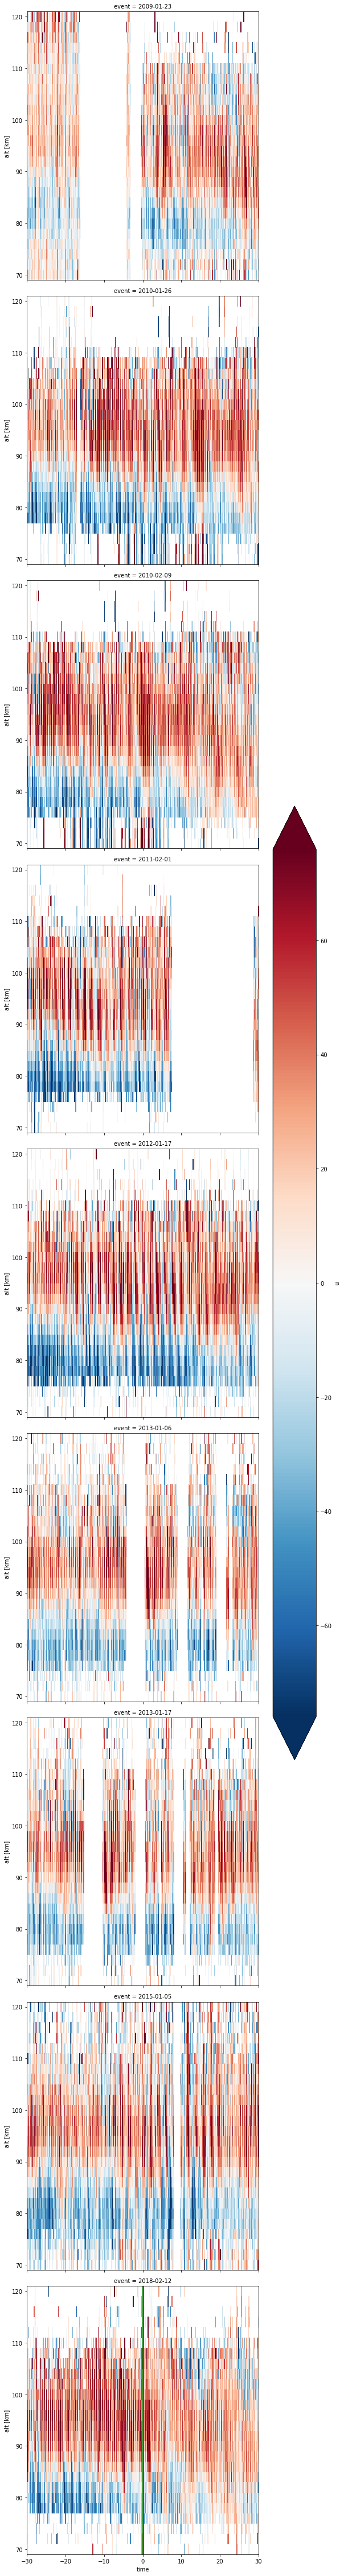

In [207]:
sea_u_rio_individual.plot(x = 'time', row = 'event', robust = True, size = 7)
plt.vlines(0,60,130, color='g', lw = 3)

In [188]:
sea_u_rio_individual

,Array,Chunk
Bytes,5.39 MB,60.74 kB
Shape,"(9, 2879, 26)","(1, 292, 26)"
Count,1167 Tasks,171 Chunks
Type,float64,numpy.ndarray


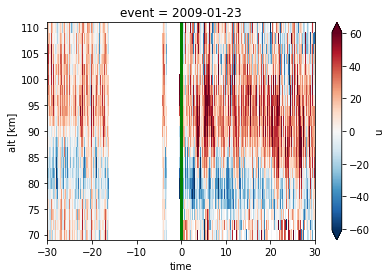

In [223]:
sea_u_rio_individual[0].sel(alt = slice(70,110)).plot(x='time',robust=True)
plt.vlines(0,60,120, color='g', lw = 3)

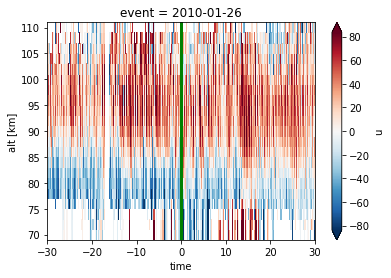

In [222]:
sea_u_rio_individual[1].sel(alt = slice(70,110)).plot(x='time',robust=True)
plt.vlines(0,60,120, color='g', lw = 3)

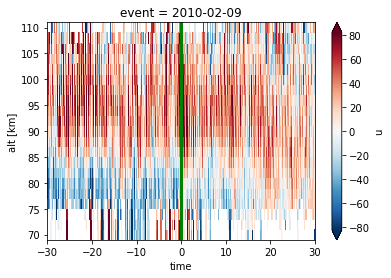

In [221]:
sea_u_rio_individual[2].sel(alt = slice(70,110)).plot(x='time',robust=True)
plt.vlines(0,60,120, color='g', lw = 3)

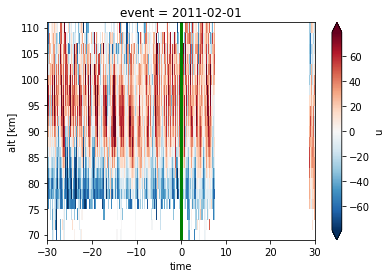

In [220]:
sea_u_rio_individual[3].sel(alt = slice(70,110)).plot(x='time',robust=True)
plt.vlines(0,60,120, color='g', lw = 3)

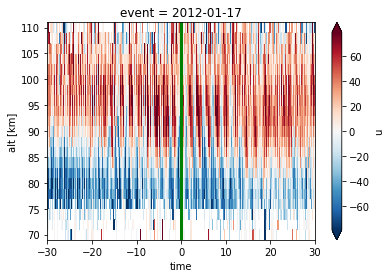

In [219]:
sea_u_rio_individual[4].sel(alt = slice(70,110)).plot(x='time',robust=True)
plt.vlines(0,60,120, color='g', lw = 3)

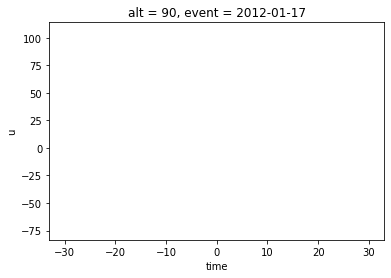

In [233]:
sea_u_rio_individual[4].sel(alt = 90, method = 'nearest').plot(x='time')

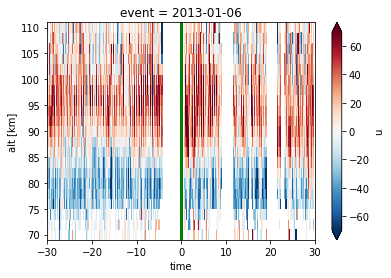

In [217]:
sea_u_rio_individual[5].sel(alt = slice(70,110)).plot(x='time',robust=True)
plt.vlines(0,60,120, color='g', lw = 3)

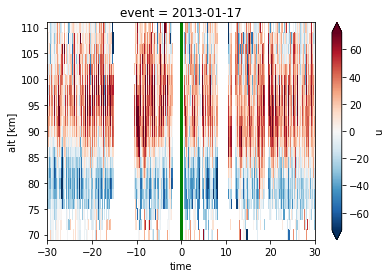

In [216]:
sea_u_rio_individual[6].sel(alt = slice(70,110)).plot(x='time',robust=True)
plt.vlines(0,60,120, color='g', lw = 3)

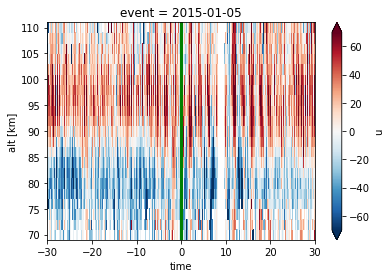

In [214]:
sea_u_rio_individual[7].sel(alt = slice(70,110)).plot(x='time',robust=True)
plt.vlines(0,60,120, color='g', lw = 3)

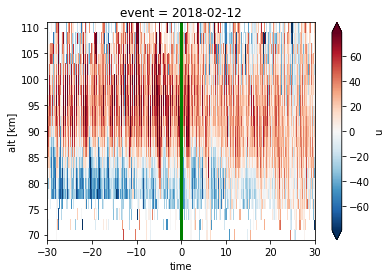

In [215]:
sea_u_rio_individual[8].sel(alt = slice(70,110)).plot(x='time',robust=True)
plt.vlines(0,60,120, color='g', lw = 3)